Bi-LSTM with Attention for AI vs Human Text Classification


This code implements a Bi-LSTM model with Attention mechanism for
distinguishing between AI and human-generated text.

The Bi-LSTM can capture contextual information from both directions,
while the attention mechanism helps the model focus on the most important
parts of the text that contribute to the classification decision.


Using device: cuda
Total number of rows in dataset: 487235
Number of rows in data subset: 100000


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Maximum token length for tokenizer: 512
Model Summary:
--------------------
attention_weights	[256, 1]	256
embedding.weight	[30522, 300]	9156600
lstm.weight_ih_l0	[512, 300]	153600
lstm.weight_hh_l0	[512, 128]	65536
lstm.bias_ih_l0	[512]	512
lstm.bias_hh_l0	[512]	512
lstm.weight_ih_l0_reverse	[512, 300]	153600
lstm.weight_hh_l0_reverse	[512, 128]	65536
lstm.bias_ih_l0_reverse	[512]	512
lstm.bias_hh_l0_reverse	[512]	512
lstm.weight_ih_l1	[512, 256]	131072
lstm.weight_hh_l1	[512, 128]	65536
lstm.bias_ih_l1	[512]	512
lstm.bias_hh_l1	[512]	512
lstm.weight_ih_l1_reverse	[512, 256]	131072
lstm.weight_hh_l1_reverse	[512, 128]	65536
lstm.bias_ih_l1_reverse	[512]	512
lstm.bias_hh_l1_reverse	[512]	512
fc.weight	[1, 256]	256
fc.bias	[1]	1
--------------------
Total Params: 9992697


Epoch 1/10: 100%|██████████| 293/293 [14:51<00:00,  3.04s/batch, training_loss=0.070]


Validation Loss: 0.044, Validation Accuracy: 0.986


Epoch 2/10: 100%|██████████| 293/293 [14:51<00:00,  3.04s/batch, training_loss=0.048]


Validation Loss: 0.026, Validation Accuracy: 0.992


Epoch 3/10: 100%|██████████| 293/293 [14:52<00:00,  3.05s/batch, training_loss=0.003]


Validation Loss: 0.029, Validation Accuracy: 0.991


Epoch 4/10: 100%|██████████| 293/293 [14:42<00:00,  3.01s/batch, training_loss=0.003]


Validation Loss: 0.020, Validation Accuracy: 0.994


Epoch 5/10: 100%|██████████| 293/293 [14:41<00:00,  3.01s/batch, training_loss=0.006]


Validation Loss: 0.021, Validation Accuracy: 0.995


Epoch 6/10: 100%|██████████| 293/293 [14:35<00:00,  2.99s/batch, training_loss=0.006]


Validation Loss: 0.043, Validation Accuracy: 0.988


Epoch 7/10: 100%|██████████| 293/293 [14:42<00:00,  3.01s/batch, training_loss=0.002]


Validation Loss: 0.022, Validation Accuracy: 0.995
Early stopping triggered. No improvement for 3 epochs.
Early stopping triggered after 7 epochs
Loaded best model with validation loss: 0.020


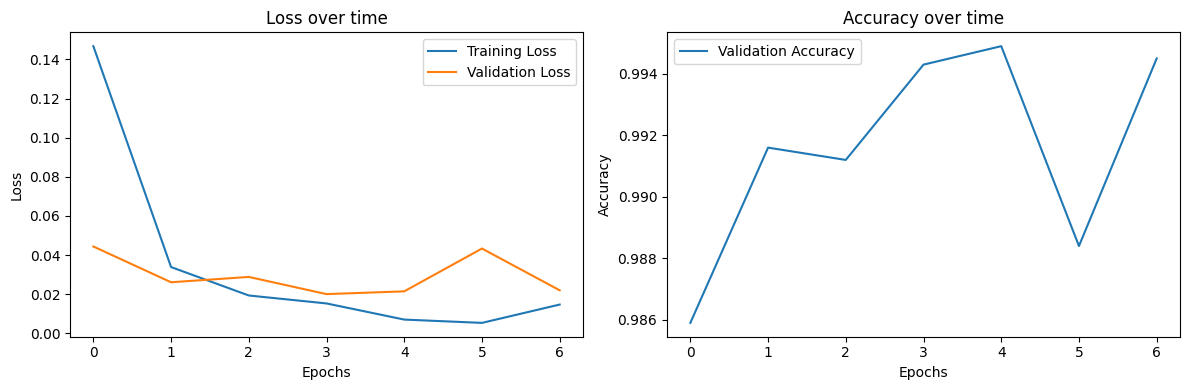

Test Loss: 0.016, Test Accuracy: 0.996
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      7499
         1.0       1.00      0.99      1.00      7501

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



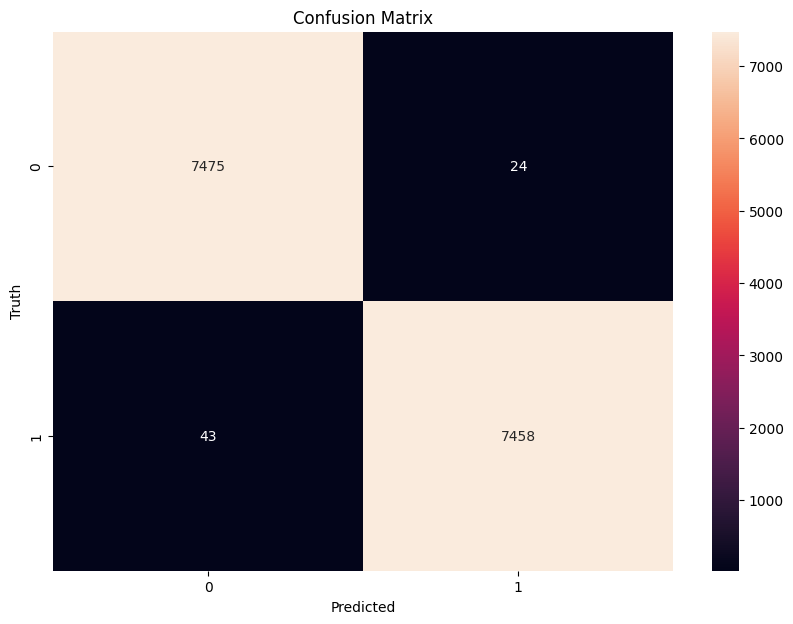

Model saved successfully!


In [10]:
# -*- coding: utf-8 -*-
"""Bi-LSTM with Attention for AI vs Human Text Classification

This code implements a Bi-LSTM model with Attention mechanism for
distinguishing between AI and human-generated text.
"""

# Libraries for basic operations
import pandas as pd
import numpy as np
from collections import Counter
import string
import random

# Tqdm for progress bars
from tqdm import tqdm

# Seaborn and matplotlib for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch for model building
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# BERT Tokenizer for tokenizing
from transformers import BertTokenizer

# Scikit-learn for model evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
set_seed(42)

# Function to load and preprocess data
def load_and_preprocess_data(csv_path, sample_size=100000):
    csv_path = '/content/AI_Human.csv'
    df = pd.read_csv('/content/AI_Human.csv')
    print(f'Total number of rows in dataset: {len(df)}')

    # Sample equal number of instances from each class
    df_zero = df[df['generated'] == 0]
    df_one = df[df['generated'] == 1]

    sample_per_class = sample_size // 2
    df_zero_sampled = df_zero.sample(sample_per_class, random_state=1)
    df_one_sampled = df_one.sample(sample_per_class, random_state=1)

    df = pd.concat([df_zero_sampled, df_one_sampled])
    df.reset_index(inplace=True)
    print(f'Number of rows in data subset: {len(df)}')

    return df

# Custom Dataset class
"""
# 3. Creating The Dataset

This Custom `TextDataset` class inherits from PyTorch's `Dataset` class.
It handles the processing of text data for model training and evaluation.
"""
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe.generated
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        # Encoding and truncating/padding to max_len
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']

        # Calculating the length of the sequence before padding
        text_length = len([token for token in ids if token != self.tokenizer.pad_token_id])

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
            'text_lengths': torch.tensor(text_length, dtype=torch.long)
        }

# Function to create data loaders
"""
    Split the dataset into training, validation, and testing sets and create data loaders

    Args:
        dataset: PyTorch Dataset object
        train_prop (float): Proportion of data for training
        val_prop (float): Proportion of data for validation
        test_prop (float): Proportion of data for testing
        batch_size (int): Batch size for data loaders

    Returns:
        tuple: (train_loader, val_loader, test_loader) - PyTorch DataLoader objects
"""
def create_data_loaders(dataset, train_prop=0.75, val_prop=0.1, test_prop=0.15, batch_size=256):
    train_len = int(train_prop * len(dataset))
    val_len = int(val_prop * len(dataset))
    test_len = int(test_prop * len(dataset))

    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Bi-LSTM with Attention model

"""
This model combines bidirectional LSTM with an attention mechanism to better capture
important parts of the text sequence. The bidirectional nature allows the model to
understand context from both past and future tokens, while attention helps focus on
the most relevant parts of the text for classification.
"""
class BiLSTMAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout_rate=0.5):
        super(BiLSTMAttentionClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(input_size=embedding_dim,
                           hidden_size=hidden_dim,
                           num_layers=num_layers,
                           batch_first=True,
                           bidirectional=True)

        # Attention layer
        self.attention_weights = nn.Parameter(torch.rand(hidden_dim * 2, 1))

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def attention_net(self, lstm_output):
        # lstm_output shape: (batch_size, seq_len, hidden_dim*2)

        # Calculate attention weights
        attn_weights = torch.tanh(lstm_output) @ self.attention_weights  # (batch_size, seq_len, 1)

        # Apply softmax to get normalized weight scores
        soft_attn_weights = F.softmax(attn_weights, dim=1)  # (batch_size, seq_len, 1)

        # Apply attention weights to LSTM output
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights)  # (batch_size, hidden_dim*2, 1)
        context = context.squeeze(2)  # (batch_size, hidden_dim*2)

        return context, soft_attn_weights

    def forward(self, input_ids, ids_len):
        # Turn words into embeddings
        ids_embedded = self.embedding(input_ids)  # (batch_size, seq_len, embedding_dim)

        # Pack the sequence of embeddings
        packed_input = pack_padded_sequence(ids_embedded, ids_len, batch_first=True)

        # Process sequence with LSTM layer
        packed_output, (hidden, cell) = self.lstm(packed_input)
        lstm_output, _ = pad_packed_sequence(packed_output, batch_first=True)  # (batch_size, seq_len, hidden_dim*2)

        # Get context vector using attention
        context, attention_weights = self.attention_net(lstm_output)

        # Apply dropout for regularization
        context = self.dropout(context)

        # Pass through fully connected layer
        output = self.fc(context)

        # Remove unnecessary dimension
        output = torch.squeeze(output, 1)

        # Apply sigmoid activation function
        output = torch.sigmoid(output)

        return output

# Print model summary
def print_model_summary(model):
    print('Model Summary:')
    print('--------------------')
    total_params = 0
    for name, parameter in model.named_parameters():
        param = parameter.numel()
        total_params += param
        print(f'{name}\t{str(list(parameter.shape))}\t{param}')
    print('--------------------')
    print(f'Total Params: {total_params}')

# Training function with Early Stopping
def train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device, patience=3):
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Early stopping variables
    best_val_loss = float('inf')
    best_model_state = None
    counter = 0
    early_stop = False

    for epoch in range(epochs):
        if early_stop:
            print(f"Early stopping triggered after {epoch} epochs")
            break
        # Performing training on all batches for an epoch
        model.train() # Setting model to training mode
        # Initializing progress bar
        train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch')

        # Initializing loss for this epoch
        epoch_train_loss = 0
        for batch in train_progress_bar:
            # Zeroing the gradients
            optimizer.zero_grad()

            # Sorting the lengths of text in descending order and getting the sorted indices
            text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
            # Using the sorted indices to rearrange the ids and targets
            ids = batch['ids'][sorted_idx]
            targets = batch['targets'][sorted_idx]

            # Moving ids and targets to the specified device
            ids = ids.to(device)
            targets = targets.to(device)

            # Forward pass and predictions
            predictions = model(ids, text_lengths)

            # Computing loss with the specified criterion
            loss = criterion(predictions, targets)

            # Backward pass: computing gradient of the loss with respect to model parameters
            loss.backward()
            # Performing a single optimization step (parameter update)
            optimizer.step()

            # Updating training loss for epoch
            epoch_train_loss += loss.item()
            # Updating progress bar
            train_progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

        # Appending average training loss for epoch
        train_losses.append(epoch_train_loss / len(train_loader))

        # Performing validation at the end of each epoch
        model.eval() # Setting the model to evaluation mode
        with torch.no_grad(): # No gradient during validation
            total_loss, total_correct, total_labels = 0, 0, 0
            for batch in val_loader:
                text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
                ids = batch['ids'][sorted_idx]
                targets = batch['targets'][sorted_idx]

                ids = ids.to(device)
                targets = targets.to(device)

                predictions = model(ids, text_lengths)
                loss = criterion(predictions, targets)

                total_loss += loss.item() * ids.size(0)
                total_correct += (predictions.round() == targets).sum().item()
                total_labels += ids.size(0)

            avg_loss = total_loss / total_labels
            avg_acc = total_correct / total_labels

            val_losses.append(avg_loss)
            val_accuracies.append(avg_acc)

            print(f'Validation Loss: {avg_loss:.3f}, Validation Accuracy: {avg_acc:.3f}')

            # Early stopping check
            if avg_loss < best_val_loss:
                best_val_loss = avg_loss
                best_model_state = model.state_dict().copy()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping triggered. No improvement for {patience} epochs.")
                    early_stop = True

    # Load best model if early stopping was triggered
    if best_model_state is not None and (early_stop or counter > 0):
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.3f}")

    return train_losses, val_losses, val_accuracies

# Evaluation function
def evaluate_model(test_loader, model, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss, total_correct, total_labels = 0, 0, 0
        all_predictions = []
        all_targets = []
        for batch in test_loader:
            text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
            ids = batch['ids'][sorted_idx]
            targets = batch['targets'][sorted_idx]

            ids = ids.to(device)
            targets = targets.to(device)

            predictions = model(ids, text_lengths)
            loss = criterion(predictions, targets)

            total_loss += loss.item() * ids.size(0)
            total_correct += (predictions.round() == targets).sum().item()
            total_labels += ids.size(0)

            all_predictions.extend(predictions.round().cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

        avg_loss = total_loss / total_labels
        avg_acc = total_correct / total_labels

        print(f'Test Loss: {avg_loss:.3f}, Test Accuracy: {avg_acc:.3f}')

        # Generating a classification report and confusion matrix
        class_report = classification_report(all_targets, all_predictions)
        conf_matrix = confusion_matrix(all_targets, all_predictions)

        print(class_report)

    return avg_loss, avg_acc, conf_matrix

# Main execution flow
def main():
    # Set device (GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Load data
    df = load_and_preprocess_data('AI_Human.csv')

    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    max_length = tokenizer.model_max_length
    print(f'Maximum token length for tokenizer: {max_length}')

    # Create dataset
    dataset = TextDataset(df, tokenizer, max_length)

    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(dataset)

    # Define model hyperparameters
    vocab_size = len(tokenizer.vocab)
    embedding_dim = 300
    hidden_dim = 128
    num_layers = 2
    dropout_rate = 0.5

    # Create model instance
    model = BiLSTMAttentionClassifier(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)
    model = model.to(device)

    # Print model summary
    print_model_summary(model)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train model with early stopping
    epochs = 10  # 增加最大訓練輪數，讓early stopping有機會工作
    patience = 3  # 連續3個epoch沒有改善就停止
    train_losses, val_losses, val_accuracies = train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device, patience=patience)

    # Visualize training progress
    plt.figure(figsize=(12, 4))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over time')
    plt.legend()

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over time')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_progress.png')
    plt.show()

    # Evaluate model on test set
    test_loss, test_acc, conf_matrix = evaluate_model(test_loader, model, criterion, device)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Save model
    torch.save(model.state_dict(), 'bi_lstm_attention_model.pt')
    print('Model saved successfully!')

if __name__ == "__main__":
    main()